https://gymnasium.farama.org/environments/box2d/lunar_lander/

### Ustawienie hardware

In [1]:
import torch

OPTIMIZE_WITH_HARDWARE = True

device = torch.device('cpu')
if OPTIMIZE_WITH_HARDWARE:
    if torch.backends.mps.is_available():
        device = torch.device('mps')
        print(f'Selected device: MPS')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        print(f'Selected device: GPU with CUDA support')
        print(f'CUDA device name: {torch.cuda.get_device_name()}')
        print(f'CUDA device count: {torch.cuda.device_count()}')
        print(f'CUDA device index: {torch.cuda.current_device()}')
else:
    print(f'Selected device: CPU')
    

Selected device: GPU with CUDA support
CUDA device name: Quadro M1200
CUDA device count: 1
CUDA device index: 0


# Ogólne przedstawienie problemu

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import gym 
env = gym.make("LunarLander-v2")

In [ ]:
import warnings
warnings.filterwarnings('ignore')

env.reset()

terminated = False
truncated = False 

while not (terminated or truncated):
    action = 1
    obs, reward, terminated, info = env.step(action)
    env.render()
    
env.close()

## Co zwraca środowisko?

Stan - wektor opisujący aktualne położenie i dynamikę lądownika.
- pozycja pozioma lądownika (x);
- pozycja pionowa lądownika (y)
- prędkość pozioma lądownika
- prędkość pionowa lądownika
- kąt nachylenia lądownika
- prędkość kątowa lądownika
- czy noga nr 1 (lewa) lądownika dotyka podłoża
- czy noga nr 2 (prawa) lądownika dotyka podłoża

## Ile akcji może wykonać agent?

In [4]:
print(f'Ilość możliwych akcji: {env.action_space.n}')

Ilość możliwych akcji: 4


1. Brak działania
2. Uruchomiony główny silnik
3. Uruchomiony lewy silnik
4. Uruchomiony peawy silnik

## Hiperparametry

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
GAMMA = 0.99 # Współczynnik dyskontowania przyszłych nagród
EPSILON_START = 1.0 # Początkowa wartość współczynnika eksploracji
EPSILON_MIN = 0.1
EPSILON_DECAY = 0.995 # Współczynnik zmniejszania wartości współczynnika eksploracji
MEMORY_SIZE = 100000 # Maksymalny rozmiar pamięci przechowującej przejścia (stan, akcja, nagroda...)
TRAIN_START = 1000 # Rozpoczęcie uczenia po zebraniu danej liczby doświadczeń

## Zaimportowanie niezbędnych bibliotek

In [6]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from collections import deque

## Struktura sieci głębokiej

- Otrzymujemy stan w postaci wektora ośmiu wyżej wymienionych parametrów. Definiujemy 3 liniowe warstwy, tzn. przetwrzające dane liniowo, realizujące sume ważoną.
- Pierwsza warstwa przyjmuje stan w którym znajduje się łazik (state_size), rozszerza na 128 parametrów.
- Druga warstwa przyjmuje 128 parametrów i na wyjściu ma 128 parametrów.
- Trzecia warstwa która będzie podawać wartość Q dla każdej możliwej do podjęcia akcji przyjmuje 128 parametrów i zwraca 4 wyjścia (action_size)

In [7]:
class DQNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Definicja agenta sieci DQN

In [ ]:
class DQNAgent:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE) #FIFO przechowujące doświadczenia
        self.model = DQNetwork(input_size, output_size).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.loss_function = nn.MSELoss()

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state): #wybiera akcję na podstawie stanu
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.output_size)
        state = torch.FloatTensor(state).to(device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
            return torch.argmax(q_values).item()#wybór najlepszej akcji) na podstawie wartości Q

    def replay(self): #replay trenuje model na podstawie doświadczeń z pamięci
        if len(self.memory) < TRAIN_START: 
            return

        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states, dones = zip(*batch) #rozdzielenie doświadczeń na listy

        states = torch.FloatTensor(states).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.model(states) #tensor zawierający wartości Q obliczone przez model dla danego stanu
        q_next = self.model(next_states).detach() 
        q_targets = q_values.clone() 

        for idx, (reward, done) in enumerate(zip(rewards, dones)):
            if done:
                q_targets[idx, actions[idx]] = reward #jeśli stan jest terminalny, wartość Q dla danej akcji jest równa nagrodzie
            else:
                q_targets[idx, actions[idx]] = reward + GAMMA * torch.max(q_next[idx]) #w przeciwnym wypadku wartość Q jest równa nagrodzie plus maksymalna wartość Q dla następnego stanu

        self.optimizer.zero_grad()
        loss = self.loss_function(q_values, q_targets)
        loss.backward()
        self.optimizer.step()

        if self.epsilon > EPSILON_MIN:
            self.epsilon *= EPSILON_DECAY

## Definicja pętli treningowej modelu

In [ ]:
import warnings
warnings.filterwarnings('ignore')

env = gym.make("LunarLander-v2", render_mode="human")
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
agent = DQNAgent(input_size, output_size)

episodes = 500
rewards_history = []

for episode in range(episodes):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        agent.memorize(state, action, reward, next_state, done)
        total_reward += reward
        state = next_state

        agent.replay() 

    rewards_history.append(total_reward)
    print(f"Episode {episode + 1}/{episodes}, Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")


Episode 1/500, Reward: -269.8614903724569, Epsilon: 1.000
Episode 2/500, Reward: -349.1196611013662, Epsilon: 1.000
Episode 3/500, Reward: -265.1674684358551, Epsilon: 1.000
Episode 4/500, Reward: -132.62790629784618, Epsilon: 1.000
Episode 5/500, Reward: -54.22907858696641, Epsilon: 1.000
Episode 6/500, Reward: 11.084620009505997, Epsilon: 1.000
Episode 7/500, Reward: -441.62319895718974, Epsilon: 1.000
Episode 8/500, Reward: -324.1476314750478, Epsilon: 1.000
Episode 9/500, Reward: -106.80641883962105, Epsilon: 1.000
Episode 10/500, Reward: -103.89202864991142, Epsilon: 1.000
Episode 11/500, Reward: -243.0410240612621, Epsilon: 0.905
Episode 12/500, Reward: -347.17704916207816, Epsilon: 0.305
Episode 13/500, Reward: -427.3784154538781, Epsilon: 0.117
Episode 14/500, Reward: -571.2481477774525, Epsilon: 0.100
Episode 15/500, Reward: -422.2649054238291, Epsilon: 0.100
Episode 16/500, Reward: -192.60433763319332, Epsilon: 0.100
Episode 17/500, Reward: -509.7729742444228, Epsilon: 0.100


## Wykresy

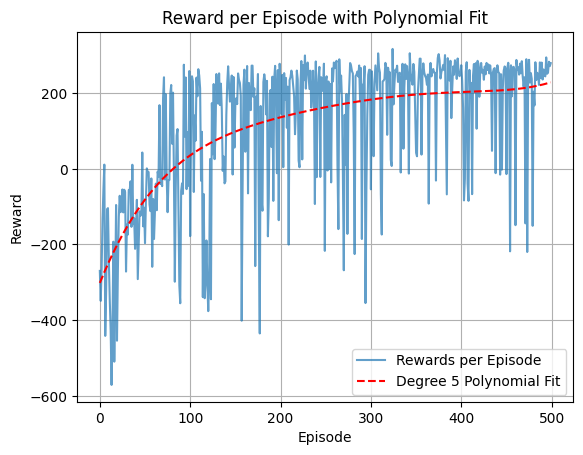

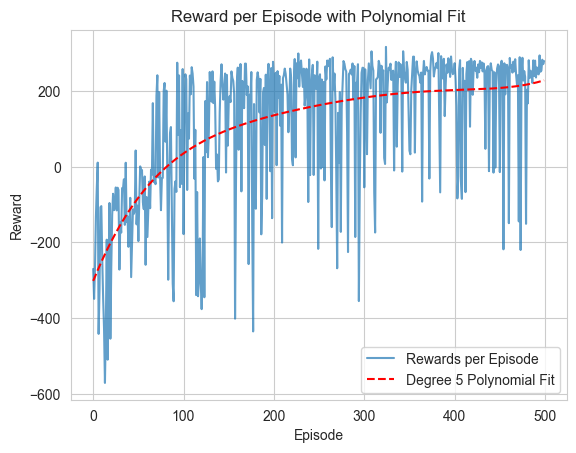

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(rewards_history, label="Rewards per Episode", alpha=0.7)
degree = 5  # Stopień wielomianu
x = np.arange(len(rewards_history))
polynomial_coefficients = np.polyfit(x, rewards_history, degree)
polynomial_fit = np.polyval(polynomial_coefficients, x)

plt.plot(x, polynomial_fit, label=f"Degree {degree} Polynomial Fit", color="red", linestyle="--")

# Konfiguracja wykresu
plt.title("Reward per Episode with Polynomial Fit")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()

import seaborn as sns


sns.set_style("whitegrid")

degree = 5  # Stopień wielomianu
x = np.arange(len(rewards_history))

# Wykres nagród w kolejnych epizodach
sns.lineplot(x=x, y=rewards_history, label="Rewards per Episode", alpha=0.7)

# Obliczenie dopasowania wielomianowego
polynomial_coefficients = np.polyfit(x, rewards_history, degree)
polynomial_fit = np.polyval(polynomial_coefficients, x)

# Wykres dopasowanego wielomianu
sns.lineplot(x=x, y=polynomial_fit, label=f"Degree {degree} Polynomial Fit", color="red", linestyle="--")

# Konfiguracja wykresu
plt.title("Reward per Episode with Polynomial Fit")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

env.close()